In [1]:
#Core Python, Pandas, and kaldi_io
import numpy as np
import pandas as pd
import string
from collections import Counter
import kaldi_io

#Scikit
from sklearn import manifold
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances,average_precision_score
from sklearn.metrics.pairwise import pairwise_kernels
from scipy import stats

#Plotting
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.spatial.distance import pdist


#Torch and utilities
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset,DataLoader,random_split,ConcatDataset

#Import User defined classes
from data_helpers import *

################################################################################
### WARNING, path does not exist: KALDI_ROOT=/mnt/matylda5/iveselyk/Tools/kaldi-trunk
###          (please add 'export KALDI_ROOT=<your_path>' in your $HOME/.profile)
###          (or run as: KALDI_ROOT=<your_path> python <your_script>.py)
################################################################################



In [2]:
#load_list = ['Data/feats_cmvn.ark']
load_list = ['Data/raw_mfcc_AMI_Segments.9.scp']
num_examples = 1000

dh = DataHelper(load_list,num_examples)

In [3]:
dh.load_data()

Length before filtering 1000
Length after filtering 539
Finished Loading the Data, 539 examples


In [4]:
dh.process_data()

In [5]:
c,word_to_num,num_to_word = dh.generate_key_dicts()

Number of Unique words  429


In [6]:
inputs,labels = dh.give_inputs_and_labels()

In [7]:
labels.shape

(539,)

In [8]:
del dh

In [2]:
def filter_on_character_length(matrices,mat_lengths,keys, char_threshold = 5):
    '''Takes in matrices and keys. Filters the data by making all keys lowercase, removing words
    with number of letters less than a threshold.'''
    
    print('Length before filtering %d'%(len(keys)))
    #Lowercase all keys
    keys = list(map(lambda x: x.translate(str.maketrans('', '', string.punctuation)).lower(),keys))
    
    #Filter if the characters are smaller than the character threshold
    matrices,mat_lengths,keys = zip(*filter(lambda x: len(x[2])>=char_threshold, zip(matrices,mat_lengths,keys)))
    
    matrices,mat_lengths,keys = list(matrices),list(mat_lengths),list(keys)
    
    print('Length after filtering %d'%(len(keys)))
    

    return matrices,mat_lengths,keys
    

In [4]:
def filter_on_character_frequency(matrices,mat_lengths,keys,frequency_bounds = (0,np.Inf)):
    '''Filter words that have frequnecy less than a lower bound threshold or more than an upper bound threshold'''
    
    print('Length before filtering %d'%(len(keys)))
    
    #Create a Counter
    c = Counter(keys)
    
    #Get the words whose frequency is below a lower bound threshold or above an upper bound threshold
    remove_list = []
    
    for key,value in c.items():
        if value < frequency_bounds[0] or value > frequency_bounds[1]:
            remove_list.append(key)
            
    #Remove the words from the Counter
    for word in remove_list:
        del c[word]
        
    #Remove the words from data
    matrices,mat_lengths,keys = zip(*filter(lambda x: x[2] not in remove_list, zip(matrices,mat_lengths,keys)))
    
    
    print('Length after filtering %d'%(len(keys)))
    
    return map(list,(matrices,mat_lengths,keys))

In [5]:
# Function to truncate and limit dimensionality
def truncate_shapes(matrices,mat_lengths,max_length = 100,num_mfcc_features = 40):
    
    for i, seq in enumerate(matrices):
        matrices[i] = matrices[i][:max_length, :num_mfcc_features]
        mat_lengths[i] = min(mat_lengths[i], max_length)
    
    return matrices,mat_lengths 

In [6]:
#Function for padding
def pad_sequences(x, n_padded, center_padded=True):
    """Return the padded sequences and their original lengths."""
    padded_x = np.zeros((len(x), n_padded, x[0].shape[1]))
    lengths = []
    for i_data, cur_x in enumerate(x):
        length = cur_x.shape[0]
        if center_padded:
            padding = int(np.round((n_padded - length) / 2.))
            if length <= n_padded:
                padded_x[i_data, padding:padding + length, :] = cur_x
            else:
                # Cut out snippet from sequence exceeding n_padded
                padded_x[i_data, :, :] = cur_x[-padding:-padding + n_padded]
            lengths.append(min(length, n_padded))
        else:
            length = min(length, n_padded)
            padded_x[i_data, :length, :] = cur_x[:length, :]
            lengths.append(length)
    return padded_x, lengths

In [7]:
def generate_key_dicts_and_labels(keys):
    '''Arguments:
    keys : A list of words corresponding to the mfcc feature matrices
    -------------
    Returns:
    labels : A list of numbers correspoding to the words in the list keys'''
    c = Counter(keys)
    #print(c)
    num_words = len(c.keys())
    word_to_num = {}
    num_to_word = {}

    index = 0
    for key in c.keys():
        word_to_num[key] = index
        num_to_word[index] = key
        index+=1

    label_list = []
    for key in keys:
        label_list.append(word_to_num[key])

    print('Number of Unique words ',len(c.keys()))
    return c,word_to_num,num_to_word,label_list

In [8]:
#Load the data
keys = []
matrices = []
mat_lengths = []

load_list = ['Data/feats_cmvn.ark']
num_examples = 200000

for load_file in load_list:
    file_keys,file_matrices,file_mat_lengths = [],[],[]
    for i,(key,matrix) in enumerate(kaldi_io.read_mat_ark(load_file)):
        file_keys.append(key.split('_')[1])
        file_matrices.append(matrix)
        file_mat_lengths.append(matrix.shape[0])
        if i == num_examples-1:
            break
            
    #Filter the data
    file_matrices,file_mat_lengths,file_keys = filter_on_character_length(file_matrices,file_mat_lengths,file_keys,char_threshold = 5)
    
    #Add to the main list
    keys.extend(file_keys)
    matrices.extend(file_matrices)
    mat_lengths.extend(file_mat_lengths)
print(len(keys))

Length before filtering 200000
Length after filtering 109486
109486


In [ ]:
#Load the data
keys = []
matrices = []
mat_lengths = []

number_list = [9,12,14,18,21,25,27,28]
load_list = ['Data/raw_mfcc_AMI_Segments.%d.scp'%(number) for number in number_list]
#load_list = ['Data/word_mfcc_features.ark']

for load_file in load_list:
    file_keys,file_matrices,file_mat_lengths = [],[],[]
    #for key,matrix in kaldi_io.read_mat_scp(load_file):
    for key,matrix in kaldi_io.read_mat_ark(load_file):
        file_keys.append(key.split('_')[1])
        file_matrices.append(matrix)
        file_mat_lengths.append(matrix.shape[0])
    #Filter the data
    #file_matrices,file_mat_lengths,file_keys = filter_on_character_length(file_matrices,file_mat_lengths,file_keys,char_threshold = 5)
    
    #Add to the main list
    keys.extend(file_keys)
    matrices.extend(file_matrices)
    mat_lengths.extend(file_mat_lengths)
print(len(keys))

In [9]:
np.mean(matrices[60].ravel())

1.4655491

In [10]:
#Make matrices zero mean
#matrices = zero_mean(matrices)

In [11]:
np.mean(matrices[60].ravel())

1.4655491

In [12]:
c = Counter(keys)
print(c)

Counter({'right': 1085, 'thats': 1047, 'think': 880, 'because': 836, 'mmhmm': 786, 'something': 779, 'maybe': 770, 'about': 696, 'remote': 620, 'buttons': 565, 'control': 546, 'really': 537, 'actually': 537, 'should': 523, 'thing': 523, 'people': 513, 'there': 499, 'things': 498, 'probably': 491, 'button': 479, 'different': 457, 'design': 451, 'which': 430, 'meeting': 401, 'alright': 387, 'screen': 379, 'could': 373, 'three': 371, 'first': 361, 'channel': 349, 'would': 347, 'gonna': 336, 'going': 335, 'stuff': 334, 'point': 330, 'doesnt': 307, 'these': 301, 'quite': 297, 'other': 291, 'rubber': 289, 'colour': 289, 'functions': 285, 'guess': 284, 'still': 282, 'project': 279, 'important': 279, 'little': 278, 'those': 278, 'problem': 276, 'interface': 276, 'whatever': 274, 'recognition': 273, 'basically': 269, 'sorry': 267, 'anything': 263, 'theres': 263, 'market': 261, 'simple': 259, 'cause': 256, 'might': 253, 'already': 251, 'information': 251, 'product': 249, 'speech': 249, 'looking'

In [13]:
#Filter the final data based on character frequencies
#matrices,mat_lengths,keys = filter_on_character_frequency(matrices,mat_lengths,keys, (4,np.Inf))

In [14]:
#Truncate the dimensions of the data
matrices,mat_lengths = truncate_shapes(matrices,mat_lengths,max_length=200,num_mfcc_features=40)
#Pad the matrices
matrices,mat_lengths = pad_sequences(matrices,n_padded = 100,center_padded = True)
matrices = np.transpose(matrices,(0,2,1))
#Generate keys and labels
c,word_to_num,num_to_word,label_list = generate_key_dicts_and_labels(keys)
#delete keys and mat_lengths
del keys,mat_lengths

Number of Unique words  8239


In [15]:
print(c)

Counter({'right': 1085, 'thats': 1047, 'think': 880, 'because': 836, 'mmhmm': 786, 'something': 779, 'maybe': 770, 'about': 696, 'remote': 620, 'buttons': 565, 'control': 546, 'really': 537, 'actually': 537, 'should': 523, 'thing': 523, 'people': 513, 'there': 499, 'things': 498, 'probably': 491, 'button': 479, 'different': 457, 'design': 451, 'which': 430, 'meeting': 401, 'alright': 387, 'screen': 379, 'could': 373, 'three': 371, 'first': 361, 'channel': 349, 'would': 347, 'gonna': 336, 'going': 335, 'stuff': 334, 'point': 330, 'doesnt': 307, 'these': 301, 'quite': 297, 'other': 291, 'rubber': 289, 'colour': 289, 'functions': 285, 'guess': 284, 'still': 282, 'project': 279, 'important': 279, 'little': 278, 'those': 278, 'problem': 276, 'interface': 276, 'whatever': 274, 'recognition': 273, 'basically': 269, 'sorry': 267, 'anything': 263, 'theres': 263, 'market': 261, 'simple': 259, 'cause': 256, 'might': 253, 'already': 251, 'information': 251, 'product': 249, 'speech': 249, 'looking'

In [16]:
print([(word,c[word]) for word in sorted(c.keys())])

[('abandon', 1), ('abbing', 1), ('abbreviated', 1), ('abbreviations', 1), ('abdul', 1), ('ability', 14), ('about', 696), ('above', 48), ('abrupt', 1), ('absolute', 15), ('absolutely', 25), ('absorb', 2), ('absorbed', 3), ('absorber', 1), ('absorbers', 4), ('absorbing', 2), ('absorp', 1), ('absorption', 54), ('abstract', 17), ('abstraction', 1), ('abstracts', 3), ('abundance', 8), ('abundances', 2), ('abutted', 1), ('accent', 2), ('accentu', 1), ('accentuate', 1), ('accept', 5), ('acceptable', 9), ('accepted', 2), ('accepting', 2), ('accepts', 2), ('access', 51), ('accessed', 1), ('accessible', 19), ('accessing', 1), ('accessories', 1), ('accessors', 1), ('accessory', 2), ('accident', 4), ('accidentally', 10), ('accommodate', 8), ('accomplish', 2), ('according', 55), ('accordingly', 8), ('account', 42), ('accountant', 1), ('accountants', 1), ('accounted', 1), ('accounting', 3), ('accounts', 2), ('accrue', 1), ('accumulate', 1), ('accuracy', 3), ('accurate', 6), ('accurately', 3), ('accu

In [17]:
dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")

In [18]:
inputs = np.stack(matrices)
del matrices
#inputs = np.expand_dims(inputs,1)
labels = np.array(label_list)
del label_list
print(inputs.shape)
print(labels.shape)

(109486, 40, 100)
(109486,)


In [19]:
#earlier random_state=42

In [20]:
x_trainval,x_test,y_trainval,y_test = train_test_split(inputs, labels, test_size=0.2, random_state=32)

In [21]:
x_train,x_val,y_train,y_val = train_test_split(x_trainval,y_trainval,test_size =0.25, random_state = 32)

In [22]:
x_train,y_train = torch.tensor(x_train,dtype= torch.float),torch.tensor(y_train, dtype= torch.float)
x_val,y_val = torch.tensor(x_val, dtype= torch.float),torch.tensor(y_val, dtype= torch.float)
x_test,y_test = torch.tensor(x_test, dtype= torch.float),torch.tensor(y_test, dtype= torch.float)

In [23]:
print(x_train.shape,y_train.shape)
print(x_val.shape,y_val.shape)
print(x_test.shape,y_test.shape)

torch.Size([65691, 40, 100]) torch.Size([65691])
torch.Size([21897, 40, 100]) torch.Size([21897])
torch.Size([21898, 40, 100]) torch.Size([21898])


In [24]:
x_train[20].squeeze()[0]

tensor([  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000, -11.2576,  -6.2086,  -5.6700,
         -2.9770,   8.3336,  29.5662,  25.0302,  26.5094,  35.9148,  39.4418,
         39.6770,  40.3824,  40.1472,  40.3824,  40.1472,  38.5013,  35.4445,
         32.6229,  28.6256,  25.5688,  22.8758,  20.9907,  18.2977,  15.3354,
         13.1810,  12.1038,  11.8345,   9.1415,   6.9871,   3.7555,   1.8704,
         -0.2840,  -2.7077,  -3.5156,  -7.2858,  -7.0165,  -8.9016, -10.9771,
         -9.7991, -10.3601, -11.2576, -11.4259, -11.7624, -12.4917, -10.3601,
        -11.7624, -11.8185, -11.4820,  -5.6700,  -4.5928,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.00

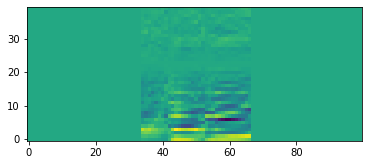

In [25]:
plt.imshow(x_train[10].squeeze(), origin = "bottom")

In [26]:
bs = 64
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, pin_memory = True, drop_last = True)

val_ds = TensorDataset(x_val, y_val)
val_dl = DataLoader(val_ds, batch_size=bs, pin_memory = True, drop_last = True)

test_ds = TensorDataset(x_test, y_test)
test_dl = DataLoader(test_ds, batch_size=bs, pin_memory = True, drop_last = True)

In [27]:
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.conv1 = nn.Conv1d(40,96,(10))
        self.pool = nn.MaxPool1d(3)
        self.conv2 = nn.Conv1d(96, 96, (8))
        #self.fc1 = nn.Linear(1728, 1024)
        self.fc1 = nn.Linear(672, 1024)
        self.fc2 = nn.Linear(1024, len(c.keys()))
        self.sm = nn.Softmax(dim = 1)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        #print(x.shape)
        x = self.pool(F.relu(self.conv2(x)))
        #print('Pre')
        #print(x.shape)  
        x = x.view(x.shape[0], -1)
        #print('Post')
        #print(x.shape)
        x = F.relu(self.fc1(x))
        #print(x.shape)
        x = F.relu(self.fc2(x))
        #print(x.shape)
        x = F.log_softmax(x,dim=1)
        #print(x.shape)
        #print("Done")
        return x
    
    def give_embeddings(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        #print(x.shape)
        x = self.pool(F.relu(self.conv2(x)))
        #print('Pre')
        #print(x.shape)  
        x = x.view(x.shape[0], -1)
        #print('Post')
        #print(x.shape)
        x = F.relu(self.fc1(x))
        #print(x.shape)
        x = F.relu(self.fc2(x))
        return x.cpu().detach().numpy() if dev.type == 'cuda' else x.detach().numpy()




In [28]:
#net = SimpleNet()
net = SimpleNet()
net = net.float()
net.to(dev)

SimpleNet(
  (conv1): Conv1d(40, 96, kernel_size=(10,), stride=(1,))
  (pool): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(96, 96, kernel_size=(8,), stride=(1,))
  (fc1): Linear(in_features=672, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=8239, bias=True)
  (sm): Softmax(dim=1)
)

In [29]:
criterion = nn.NLLLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [30]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

In [31]:
def train_model(net,num_epochs,train_dl,val_dl,save_path = "./Models/",verbose = True):
    
    hist = {}
    train_acc_list = []
    val_acc_list = []
    train_loss_list = []
    val_loss_list = []
    
    best_val_loss = np.Inf
    best_val_acc = np.NINF
    print('Starting Training')
    for epoch in range(0,num_epochs):  # loop over the dataset multiple times
        if verbose:
            print('epoch %d '%(epoch))

        train_loss = 0
        train_acc = 0
        net.train()
        for xb,yb in train_dl:
            
            #Move to GPU
            xb,yb = xb.to(dev, non_blocking=True),yb.to(dev, non_blocking=True)
            
            # get the inputs; data is a list of [inputs, labels]
            #inputs, labels = torch.tensor(inputs),torch.tensor(labels)
            #labels = labels.long()
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(xb)
            loss = criterion(outputs, yb.long())
            train_loss += loss
            train_acc += accuracy(outputs,yb)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss = loss.item()
        net.eval()
        with torch.no_grad():
            val_loss = 0
            val_acc = 0
            for xb,yb in val_dl:
                
                #Move to GPU
                xb,yb = xb.to(dev, non_blocking=True),yb.to(dev, non_blocking=True)
                
                #get predictions
                y_pred = net(xb)
                
                val_loss += criterion(y_pred,yb.long())
                val_acc += accuracy(y_pred, yb.long())
            #val_loss = sum(criterion(net(xb), yb.long()) for xb, yb in val_dl)
            #val_acc = sum(accuracy(net(xb), yb.long()) for xb, yb in val_dl)
            if val_acc.cpu().detach().numpy() > best_val_acc:
                best_val_acc = val_acc.cpu().detach().numpy()
                path = save_path + "l2_best_model.pth"
                if verbose:
                    print("Best val acc. Saving model...")
                torch.save(net.state_dict(), path)

        train_loss_list.append(train_loss.item()/len(train_dl))
        train_acc_list.append(train_acc.item()/len(train_dl))
        val_loss_list.append(val_loss.item()/len(val_dl))
        val_acc_list.append(val_acc.item()/len(val_dl))
        
        if verbose:
            print("train loss: %.3f train acc: %.3f"%(train_loss/len(train_dl),train_acc/len(train_dl)))
            print("val loss: %.3f val acc: %.3f"%(val_loss/len(val_dl),val_acc/len(val_dl)))
        if epoch%5 == 0:
            path = save_path + "simple_awe_bs64_epoch_%d.pth"%(epoch)
            torch.save(net.state_dict(), path)

    
    hist['train_acc'] = train_acc_list
    hist['val_acc'] = val_acc_list
    hist['train_loss'] = train_loss_list
    hist['val_loss'] = val_loss_list
    print('Finished Training')
    return hist

In [32]:
def evaluate_model_old(net,test_dl, diagonal_pairs = True):
    
    embeddings = None
    labels = None
    for xb,yb in test_dl:
        #If device is GPU move features to GPU
        if dev.type == 'cuda' and not xb.is_cuda:
            xb = xb.to(dev, non_blocking=True)
            
        #Get the embeddings
        #batch_embeddings = net.give_embeddings(xb)
        batch_embeddings = net(xb).cpu().detach().numpy()
        
        #Add to the main embeddings
        if embeddings is not None:
            embeddings = np.vstack((embeddings, batch_embeddings))
            labels = np.concatenate((labels,yb),axis=0)
        else:
            embeddings = batch_embeddings
            labels = yb


    
    #Calculate pairwise cosine distance
    distances = pairwise_distances(embeddings, metric='cosine')
    #Calculate pairwise cosine similarity
    similarity = pairwise_kernels(embeddings, metric = 'cosine')
    
    
    
    #Create labels of whether the words are same or not
    if torch.is_tensor(labels):
        labels = labels.detach().numpy()
        
    eval_labels = (labels[:,None]==labels).astype(float)
    
    
    if not diagonal_pairs:
        #Remove the diagonal elements (word pairs with themselves)
        mask = np.array(np.tril(np.ones((similarity.shape[0],similarity.shape[0])),-1),dtype = bool)
        similarity = similarity[mask]
        distances = distances[mask]
        eval_labels = eval_labels[mask]
        
    #flatten the pairwise arrays
    distances = np.ravel(distances)
    similarity = np.ravel(similarity)
    #Flatten the labels
    eval_labels = np.ravel(eval_labels)
    
    num_positive = sum(eval_labels==1)
    num_negative = eval_labels.shape[0]-num_positive
    print('The number of positive examples %d and negative examples %d'%(num_positive,num_negative))
    #Calculate the Average Precision
    avg_p = average_precision_score(eval_labels,similarity)
    #avg_p = average_precision_score(eval_labels,2-distances)
    #avg_p = average_precision_score(eval_labels,2-distances)
    print('Average Precision is %f'%(avg_p))

            
            

In [33]:
def plot_learning_curves(hist, num_epochs,name = 'learning_curves.png'):
    
    fig, axs = plt.subplots(2, 1, figsize = (9,9))

    axs[0].plot(np.arange(0,num_epochs,1), hist['train_loss'], label = "train_acc")
    axs[0].plot(np.arange(0,num_epochs,1),hist['val_loss'], label = "val_acc")
    axs[0].legend(loc = "best")
    axs[0].set_xlabel("Epochs")
    axs[0].set_ylabel("Loss")
    axs[0].set_title("Learning Curves (Loss)")

    axs[1].plot(np.arange(0,num_epochs,1),list(map(lambda x: x*100,hist['train_acc'])), label = "train_acc")
    axs[1].plot(np.arange(0,num_epochs,1),list(map(lambda x: x*100,hist['val_acc'])), label = "val_acc")
    axs[1].legend(loc = "best")
    axs[1].set_xlabel("Epochs")
    axs[1].set_ylabel("Accuracy (in %)")
    axs[1].set_title("Learning Curves (Accuracy)")




    fig.tight_layout(pad = 2.0)
    plt.savefig(name)
    plt.show()
    

In [34]:
train = False
num_epochs = 100

In [35]:
hist = None
if train:
    hist = train_model(net,num_epochs,train_dl,val_dl,save_path="./temp_aurora/",verbose = True)
else:
    print('Not training the model')

Not training the model


In [36]:
if train:
    plot_learning_curves(hist, num_epochs,name = 'learning_curves_new_AMI.png')

In [37]:
def run_data_study(splits,num_epochs,train_ds,val_dl):
    lengths = [int(len(train_ds)*(1/splits)) for  i in range(splits)]
    
    if sum(lengths) != len(train_ds):
        lengths.append(len(train_ds) - sum(lengths))
        
    
    iteration_datasets = list(random_split(train_ds, lengths))
    
    #Remove the last element
    lengths = lengths[:-1]
    iteration_datasets = iteration_datasets[:-1]
    iteration_best_train_loss = []
    iteration_best_val_loss = []
    iteration_best_train_acc = []
    iteration_best_val_acc = []
    
    for iteration in range(splits):
        print('Iteration %d'%(iteration))
        iteration_ds = ConcatDataset(iteration_datasets[:iteration+1])
        iteration_dl = DataLoader(iteration_ds, batch_size=bs, pin_memory = True, drop_last = True)
        
        print('Training set having %d examples'%(len(iteration_ds)))
        #Create model
        net = SimpleNet()
        net = net.float()
        net.to(dev)
        
        hist = train_model(net,num_epochs,iteration_dl,val_dl,save_path="./data_study/", verbose = False)
        
        #Delete model
        del net
        
        best_train_loss = min(hist['train_loss'])
        best_val_loss = min(hist['val_loss'])
        best_train_acc = max(hist['train_acc'])
        best_val_acc = max(hist['val_acc'])
        
        iteration_best_train_loss.append(best_train_loss)
        iteration_best_val_loss.append(best_val_loss)
        iteration_best_train_acc.append(best_train_acc)
        iteration_best_val_acc.append(best_val_acc)
    
    #Plot the data study curves
    fig, axs = plt.subplots(2, 1, figsize = (9,9))

    axs[0].plot(np.arange(0,splits,1),iteration_best_train_loss, label = "train_acc")
    axs[0].plot(np.arange(0,splits,1),iteration_best_val_loss, label = "val_acc")
    axs[0].legend(loc = "best")
    axs[0].set_xlabel("Splits")
    axs[0].set_ylabel("Best Loss")
    axs[0].set_title("Data Splits vs Loss")

    axs[1].plot(np.arange(1,splits+1,1)*100/(splits),list(map(lambda x: x*100,iteration_best_train_acc)), label = "train_acc")
    axs[1].plot(np.arange(1,splits+1,1)*100/(splits),list(map(lambda x: x*100,iteration_best_val_acc)), label = "val_acc")
    axs[1].legend(loc = "best")
    axs[1].set_xlabel("Data Used (%)")
    axs[1].set_ylabel("Best Accuracy (in %)")
    axs[1].set_title("Data Splits vs Accuracy")



    name = 'data_study.png'
    fig.tight_layout(pad = 2.0)
    plt.savefig(name)
    plt.show()
        
        

In [38]:
#run_data_study(splits = 5,num_epochs = 100,train_ds = train_ds,val_dl = val_dl)

In [39]:
#Load the best model
best_model_path = "./Models/new_AMI_best_model.pth"
net.load_state_dict(torch.load(best_model_path))

<All keys matched successfully>

In [40]:
test_acc = 0
if dev.type == 'cuda':
    for xb,yb in test_dl:
        #Move to GPU
        xb,yb = xb.to(dev, non_blocking=True),yb.to(dev, non_blocking=True)
        y_pred = net(xb)
        test_acc += accuracy(y_pred,yb.long())
    test_acc = test_acc/len(test_dl)
elif dev.type == 'cpu':
    for xb,yb in test_dl:
        if xb.shape[0]<64:
            continue
        y_pred = net(x_test)
        test_acc += accuracy(y_pred,yb.long())
    test_acc = test_acc/len(test_dl)
    
print("Test Accuracy of best model is %.3f"%(test_acc))

Test Accuracy of best model is 0.473


In [41]:
def generate_matches_array(labels):
    """
    Return an array of bool in the same order as the distances from
    `scipy.spatial.distance.pdist` indicating whether a distance is for
    matching or non-matching labels.
    """
    N = len(labels)
    matches = np.zeros(int(N*(N - 1)/2), dtype=np.bool)

    # For every distance, mark whether it is a true match or not
    cur_matches_i = 0
    for n in range(N):
        cur_label = labels[n]
        matches[cur_matches_i:cur_matches_i + (N - n) - 1] = np.asarray(labels[n + 1:]) == cur_label
        cur_matches_i += N - n - 1

    return matches

In [42]:
def evaluate_model(net,evaluate_dl, show_plot = True):
    
    embeddings = None
    labels = None
    for xb,yb in evaluate_dl:
        #If device is GPU move features to GPU
        if dev.type == 'cuda' and not xb.is_cuda:
            xb = xb.to(dev, non_blocking=True)
            
        #Get the embeddings
        #batch_embeddings = net.give_embeddings(xb)
        batch_embeddings = net(xb).cpu().detach().numpy()
        
        #Add to the main embeddings
        if embeddings is not None:
            embeddings = np.vstack((embeddings, batch_embeddings))
            labels = np.concatenate((labels,yb),axis=0)
        else:
            embeddings = batch_embeddings
            labels = yb


    print('Finished getting %d embeddings'%(embeddings.shape[0]))
    #Calculate pairwise cosine distance
    distances = pdist(embeddings,metric = 'cosine')
    #Getting matches array
    matches = generate_matches_array(labels)
    
    
    pos_distances =  distances[matches == True]
    neg_distances = distances[matches == False]
    
    distances = np.concatenate([pos_distances, neg_distances])
    matches = np.concatenate([np.ones(len(pos_distances)), np.zeros(len(neg_distances))])
    
    
    
    sorted_i = np.argsort(distances)
    distances = distances[sorted_i]
    matches = matches[sorted_i]
    
    
    # Calculate precision
    precision = np.cumsum(matches)/np.arange(1, len(matches) + 1)
    
    
    # Calculate average precision: the multiplication with matches and division
    # by the number of positive examples is to not count precisions at the same
    # recall point multiple times.
    average_precision = np.sum(precision * matches) / len(pos_distances)
    print('Average Precision is %f'%(average_precision))
    # Calculate recall
    recall = np.cumsum(matches)/len(pos_distances)
    
    # More than one precision can be at a single recall point, take the max one
    for n in range(len(recall) - 2, -1, -1):
        precision[n] = max(precision[n], precision[n + 1])
        
    # Calculate precision-recall breakeven
    prb_i = np.argmin(np.abs(recall - precision))
    prb = (recall[prb_i] + precision[prb_i])/2.
    
    if show_plot:
        import matplotlib.pyplot as plt
        plt.plot(recall, precision)
        plt.xlabel("Recall")
        plt.ylabel("Precision")
    
    

            
            

In [43]:
evaluate_dl = DataLoader(test_ds, batch_size=1024, pin_memory = True, drop_last = False)

Finished getting 21898 embeddings
Average Precision is 0.040263


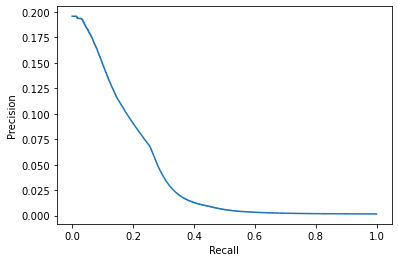

In [44]:
evaluate_model(net,evaluate_dl,show_plot = True)

In [ ]:
evaluate_model_old(net,evaluate_dl,diagonal_pairs = False)

In [54]:
#evaluate_model(net,val_dl,diagonal_pairs = False)

In [45]:
train_words = set([num_to_word[y_train[i].item()] for i in range(y_train.shape[0])])
val_words = set([num_to_word[y_val[i].item()] for i in range(y_val.shape[0])])
test_words = set([num_to_word[y_test[i].item()] for i in range(y_test.shape[0])])

In [48]:
len(test_words)

3948

In [49]:
len(test_words - train_words)

831

In [50]:
831/3948

0.21048632218844984

In [56]:
def give_tsne(net,visualization_dl):
    
    embeddings = None
    for i,(xb,yb) in enumerate(visualization_dl):
        #If device is GPU move features to GPU
        if dev.type == 'cuda' and not xb.is_cuda:
            xb = xb.to(dev, non_blocking=True)
            if embeddings is not None:
                print(embeddings.shape[0])
            
        #Get the embeddings
        batch_embeddings = net.give_embeddings(xb)
        
        #Add to the main embeddings
        if embeddings is not None:
            embeddings = np.vstack((embeddings, batch_embeddings))
        else:
            embeddings = batch_embeddings
            
    tsne = manifold.TSNE(n_components=2, verbose=1, perplexity=40, n_iter=500)
    tsne_vectors = tsne.fit_transform(embeddings)
    
    return tsne_vectors


In [57]:
def add_membership(word):
    train_tag = "Tr" if word in train_words else ""
    val_tag = "|Val" if word in val_words else ""
    test_tag = "|Ts" if word in test_words else ""
    return word+" (%s%s%s)"%(train_tag,val_tag,test_tag)

In [58]:
def visualize_words(word_list,tsne_vectors,labels,rigid_limits = False):
    #Get ids of words from labels
    num_list = [word_to_num[word] for word in word_list]
    ids = np.where(np.isin(labels,np.array(num_list)))
    
    df_subset = {}
    df_subset['tsne-2d-one'] = tsne_vectors[ids][:,0]
    df_subset['tsne-2d-two'] = tsne_vectors[ids][:,1]
    df_subset['Word'] = [num_to_word[labels[ids][i].item()] for i in range(ids[0].shape[0])]
    
    #Convert to dataframe
    df_subset = pd.DataFrame(df_subset)
    #Add membership tags
    df_subset['Word'] = df_subset['Word'].apply(add_membership)
    
    #print(df_subset['tsne-2d-one'].shape)
    #print(df_subset['tsne-2d-two'].shape)
    #print(len(df_subset['y']))
    
    #print(ids)
    #print(df_subset['y'])
    
    g = sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="Word",
    data=df_subset,
    legend="full",
    alpha=0.5)
    g.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
    
    if rigid_limits:
        x_coordinate = tsne_vectors[:,0]
        y_coordinate = tsne_vectors[:,1]
        epsilon = 5
        plt.xlim(min(x_coordinate)-epsilon,max(x_coordinate)+epsilon)
        plt.ylim(min(y_coordinate)-epsilon,max(y_coordinate)+epsilon)
    

In [79]:
visualization_ds = TensorDataset(torch.tensor(inputs,dtype= torch.float),torch.tensor(labels, dtype= torch.float))
visualization_dl = DataLoader(visualization_ds, batch_size=1024, pin_memory = True, drop_last = False)
tsne_vectors = give_tsne(net,visualization_dl)

1024
2048
3072
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3449 samples in 0.641s...
[t-SNE] Computed neighbors for 3449 samples in 16.523s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3449
[t-SNE] Computed conditional probabilities for sample 2000 / 3449
[t-SNE] Computed conditional probabilities for sample 3000 / 3449
[t-SNE] Computed conditional probabilities for sample 3449 / 3449
[t-SNE] Mean sigma: 0.000507
[t-SNE] KL divergence after 250 iterations with early exaggeration: 81.913239
[t-SNE] KL divergence after 500 iterations: 1.504368


In [80]:
x_coordinate = tsne_vectors[:,0]
y_coordinate = tsne_vectors[:,1]
epsilon = 5
print(min(x_coordinate)-epsilon,max(x_coordinate)+epsilon)
print(min(y_coordinate)-epsilon,max(y_coordinate)+epsilon)

-47.14128112792969 50.3733024597168
-48.8997688293457 57.878501892089844


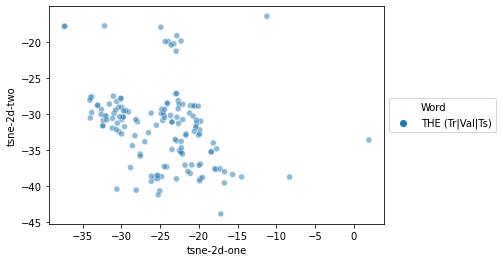

In [81]:
word_list = ["THE"]
visualize_words(word_list,tsne_vectors,labels)

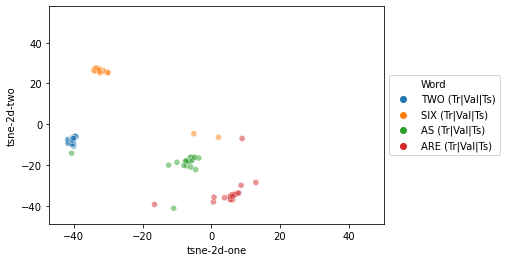

In [102]:
word_list = ["AS","ARE","TWO","SIX"]
visualize_words(word_list,tsne_vectors,labels,True)

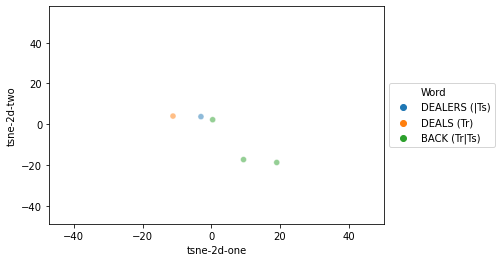

In [103]:
word_list = ["DEALERS","DEALS","BACK"]
visualize_words(word_list,tsne_vectors,labels,True)

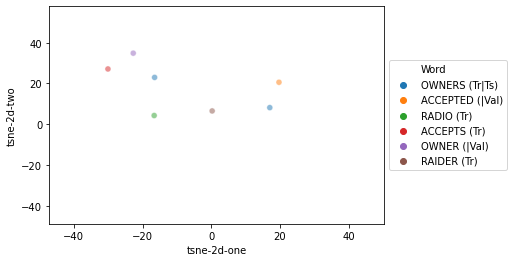

In [104]:
word_list = ["ACCEPTED","ACCEPTS","RADIO","RAIDER","OWNER","OWNERS"]
visualize_words(word_list,tsne_vectors,labels,True)

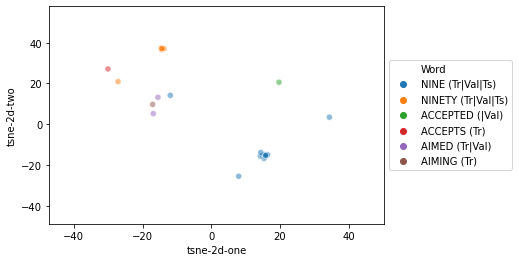

In [105]:
word_list = ["NINE","NINETY","ACCEPTED","ACCEPTS","AIMED","AIMING"]
visualize_words(word_list,tsne_vectors,labels,True)

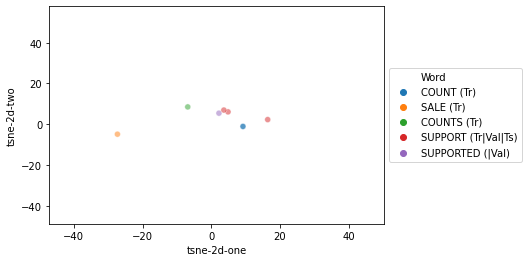

In [106]:
word_list = ["COUNT","COUNTS","SALE","SUPPORT","SUPPORTED"]
visualize_words(word_list,tsne_vectors,labels,True)

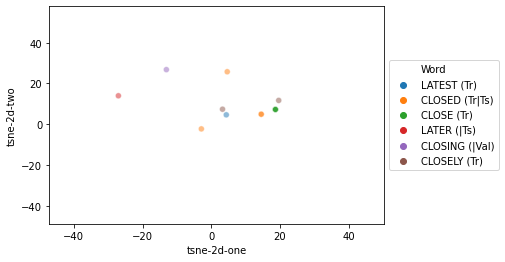

In [107]:
word_list = ["LATER","LATEST","CLOSE","CLOSING","CLOSED","CLOSELY"]
visualize_words(word_list,tsne_vectors,labels,True)

In [112]:
def nearest_neighbors(net,inputs,labels,n_neighbors = 3):
    
    if dev.type == 'cuda':
        inputs = inputs.to(dev, non_blocking = True)
    embeddings = net.give_embeddings(inputs)
    nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='brute',metric = 'euclidean').fit(embeddings)
    distances,indices = nbrs.kneighbors(embeddings)
    
    return distances,indices
    

In [113]:
def nearest_neighbors_for_word(word,indices,labels):
    
    num_list = [word_to_num[word]]
    ids = np.where(np.isin(labels,np.array(num_list)))
    neighbor_indices = indices[ids]
    
    for i in range(neighbor_indices.shape[0]):
        neighboring_words = [num_to_word[labels[neighbor_indices[i,j]]] for j in range(neighbor_indices.shape[1])]
        print(neighboring_words)
    

In [114]:
distances,indices = nearest_neighbors(net,torch.tensor(inputs,dtype=torch.float),labels,n_neighbors=5)

In [115]:
word = "SUPPORT"
nearest_neighbors_for_word(word,indices,labels)

['SUPPORT', 'CLIMB', 'PROBABLY', 'AIRCRAFT', 'DIRECT']
['SUPPORT', 'OPERATOR', 'AIRCRAFT', 'HOLDING', 'SHARES']
['LIKELY', 'COMING', 'OPERATOR', 'SHARES', 'SURPRISE']


In [116]:
word = "LATER"
nearest_neighbors_for_word(word,indices,labels)

['LATER', 'UNDER', 'HUNDRED', 'UNDER', 'HUNDRED']


In [117]:
word = "CLOSING"
nearest_neighbors_for_word(word,indices,labels)

['CLOSING', 'WASHINGTON', 'AFTER', 'OPPOSITION', 'COMMENT']


In [118]:
word = "ACCEPTED"
nearest_neighbors_for_word(word,indices,labels)

['ACCEPTED', 'INFLATION', 'PURCHASES', 'PROCESS', 'SPLIT']


In [119]:
word = "DEALS"
nearest_neighbors_for_word(word,indices,labels)

['DEALS', 'PUBLICLY', 'FINANCIAL', 'FINANCIAL', 'EXPOSURE']


In [120]:
word = "ACCEPTS"
nearest_neighbors_for_word(word,indices,labels)

['ACCEPTS', 'SIX', 'BUSINESS', 'SIX', 'SINCE']


In [121]:
word = "DAY"
nearest_neighbors_for_word(word,indices,labels)

['DAY', 'MAY', 'MAY', 'MAY', 'EIGHT']
['DAY', 'BIDS', 'MAY', 'DAY', 'BASED']
['DAY', 'DAY', 'MAY', 'BIDS', 'BASED']
['DAY', 'YOU', 'HUNDRED', 'UNDER', 'CLEAR']


In [122]:
word = "DEALERS"
nearest_neighbors_for_word(word,indices,labels)

['DEALERS', 'LANGUAGE', 'GROUP', 'TOO', 'PREVIOUS']
